## Implémentation de DQN pour l'environnement Gym CartPole avec l'architecture Fixed Q values 

Ce notebook est juste une copie manuelle du DQN proposé par [Aurélien Géron](https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb) pour maîtriser l'équilibre d'un pendule inversé. Il vise uniquement à s'approprier les techniques de codage pour avoir une base performante avant de complexifier l'environnement et la tâche à réaliser par l'agent. 

A noter que l'affichage qui permet en général d'attester la qualité et la performance d'un DQN présente la somme des récompenses par épisode et non la loss qui n'est pas représentative de la qualité de l'apprentissage. Dans ce notebook, on explore la technique Fixed Q values qui consistent à créer deux modèles : un pour chaque côté de l'équation de Bellman target et training. On entraîne  

In [1]:
# Importer les librairies nécessaires

import gym
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [2]:
# Mise en place de l'agent et du DQN

def def_model(input_nb, output_nb):
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation="elu", input_shape=input_nb),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(output_nb)])
    return model

def epsilon_greedy_policy(state, nb_outputs, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(nb_outputs)
    else:
        Q_values = Training.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [3]:
# Mise en place du stockage d'expériences

from collections import deque

replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [4]:
# Mise en place de l'environnement d'exécution

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, n_outputs, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [5]:
# Mise en place de la procédure d'entraînement

env = gym.make("CartPole-v0")
input_shape=[4]
n_outputs=2

batch_size = 32
gamma = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

Training = def_model(input_shape, n_outputs)
Target = def_model(input_shape, n_outputs)

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    Qval_next_target = Target.predict(next_states)
    max_Qval_next_target = np.max(Qval_next_target, axis=1)
    Qval_target = (rewards + (1-dones) * gamma * max_Qval_next_target)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        Qval_all_train = Training(states)
        Qval_train = tf.reduce_sum(Qval_all_train * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(Qval_target, Qval_train))
    grads = tape.gradient(loss, Training.trainable_variables)
    optimizer.apply_gradients(zip(grads, Training.trainable_variables))

In [6]:
rewards=[]
maxi=0

for episode in tqdm(range(600)):
    obs = env.reset()
    sum=0
    for step in range(200):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
        sum+=reward
    rewards.append(sum)
    
    if sum>50 and sum>maxi:
        Target.save('cartpole')
        maxi=sum
    
    if episode > 50:
        training_step(batch_size)
        
    if episode % 50 ==0:
        Target.set_weights(Training.get_weights())
print('maxi = {}'.format(maxi))

  8%|██████▎                                                                          | 47/600 [00:04<01:39,  5.58it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cartpole\assets


  8%|██████▉                                                                          | 51/600 [00:06<03:31,  2.60it/s]

INFO:tensorflow:Assets written to: cartpole\assets

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  9%|███████▍                                                                         | 55/600 [00:09<03:53,  2.34it/s]

INFO:tensorflow:Assets written to: cartpole\assets


 19%|███████████████▎                                                                | 115/600 [00:33<04:23,  1.84it/s]

INFO:tensorflow:Assets written to: cartpole\assets


 38%|██████████████████████████████▊                                                 | 231/600 [01:34<06:05,  1.01it/s]

INFO:tensorflow:Assets written to: cartpole\assets


 49%|███████████████████████████████████████▏                                        | 294/600 [02:35<04:31,  1.13it/s]

INFO:tensorflow:Assets written to: cartpole\assets


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [13:21<00:00,  1.34s/it]

maxi = 199.0


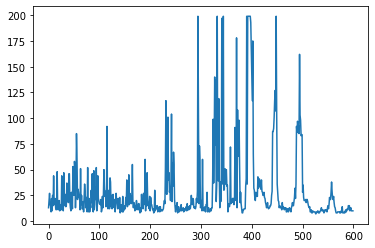

In [8]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.show()

In [9]:
import tensorflow as tf 

model = tf.keras.models.load_model('cartpole')

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________


In [12]:
import gym
from tqdm import tqdm 
import numpy as np

env = gym.make('CartPole-v0')
state = env.reset()
for i in tqdm(range(500)):
    env.render()
    Q_values = model.predict(state[np.newaxis])
    state, _, done, _ = env.step(np.argmax(Q_values[0])) # take a random action
    
env.close()

  2%|█▊                                                                               | 11/500 [00:01<00:45, 10.77it/s]C:\Users\User\anaconda3\envs\OpenAI\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.50it/s]
